# 04_DenseNet121

### (6) 사용하는 전이학습 방법(모델 및 사용법)의 구체적 설명 + 딥네트웍 구조 도식화 및 설명

🔹 전이학습 개요

DenseNet121은 각 층이 이전 모든 층의 feature map을 연결(concatenate)하여 전달하는 구조를 갖는 딥러닝 모델입니다. 이런 특성 덕분에 파라미터 수를 줄이면서도 효율적으로 특징을 학습할 수 있습니다. 본 프로젝트에서는 ImageNet으로 사전학습된 가중치를 활용해 소량의 칼 이미지 데이터를 효과적으로 분류하기 위해 전이학습을 적용하였습니다.

🔹 사용 방식

weights='imagenet': ImageNet에서 학습된 가중치를 불러와 기본 특징 추출기로 활용

include_top=False: 원래의 fully connected 층 제거, 새로운 분류기 구성

trainable=False: DenseNet의 기존 가중치는 고정하여 feature extractor로만 사용

🔹 전체 모델 구조



```
[입력 이미지 (224, 224, 3)]
        ↓
[DenseNet121 (include_top=False)]
        ↓
[GlobalAveragePooling2D]
        ↓
[Dense(128, relu)]
        ↓
[Dense(3, softmax)]  ← 3개의 칼 종류 분류
```


🔹 도식 설명

DenseNet121: 각 층이 이전 모든 층의 출력을 입력으로 받는 dense connection 구조를 갖춘 CNN

GlobalAveragePooling2D: feature map을 평균값으로 압축하여 벡터화, 과적합 방지

Dense(128, ReLU): 중간 은닉층을 통해 비선형성을 추가하고 표현력 향상

Dense(3, Softmax): 최종 출력층으로, 식칼/과도/커터칼 3종을 분류

In [ ]:
# 한글 폰트 설치 (나눔체) - 시각화 시 用

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (5,041 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126109 files and dire

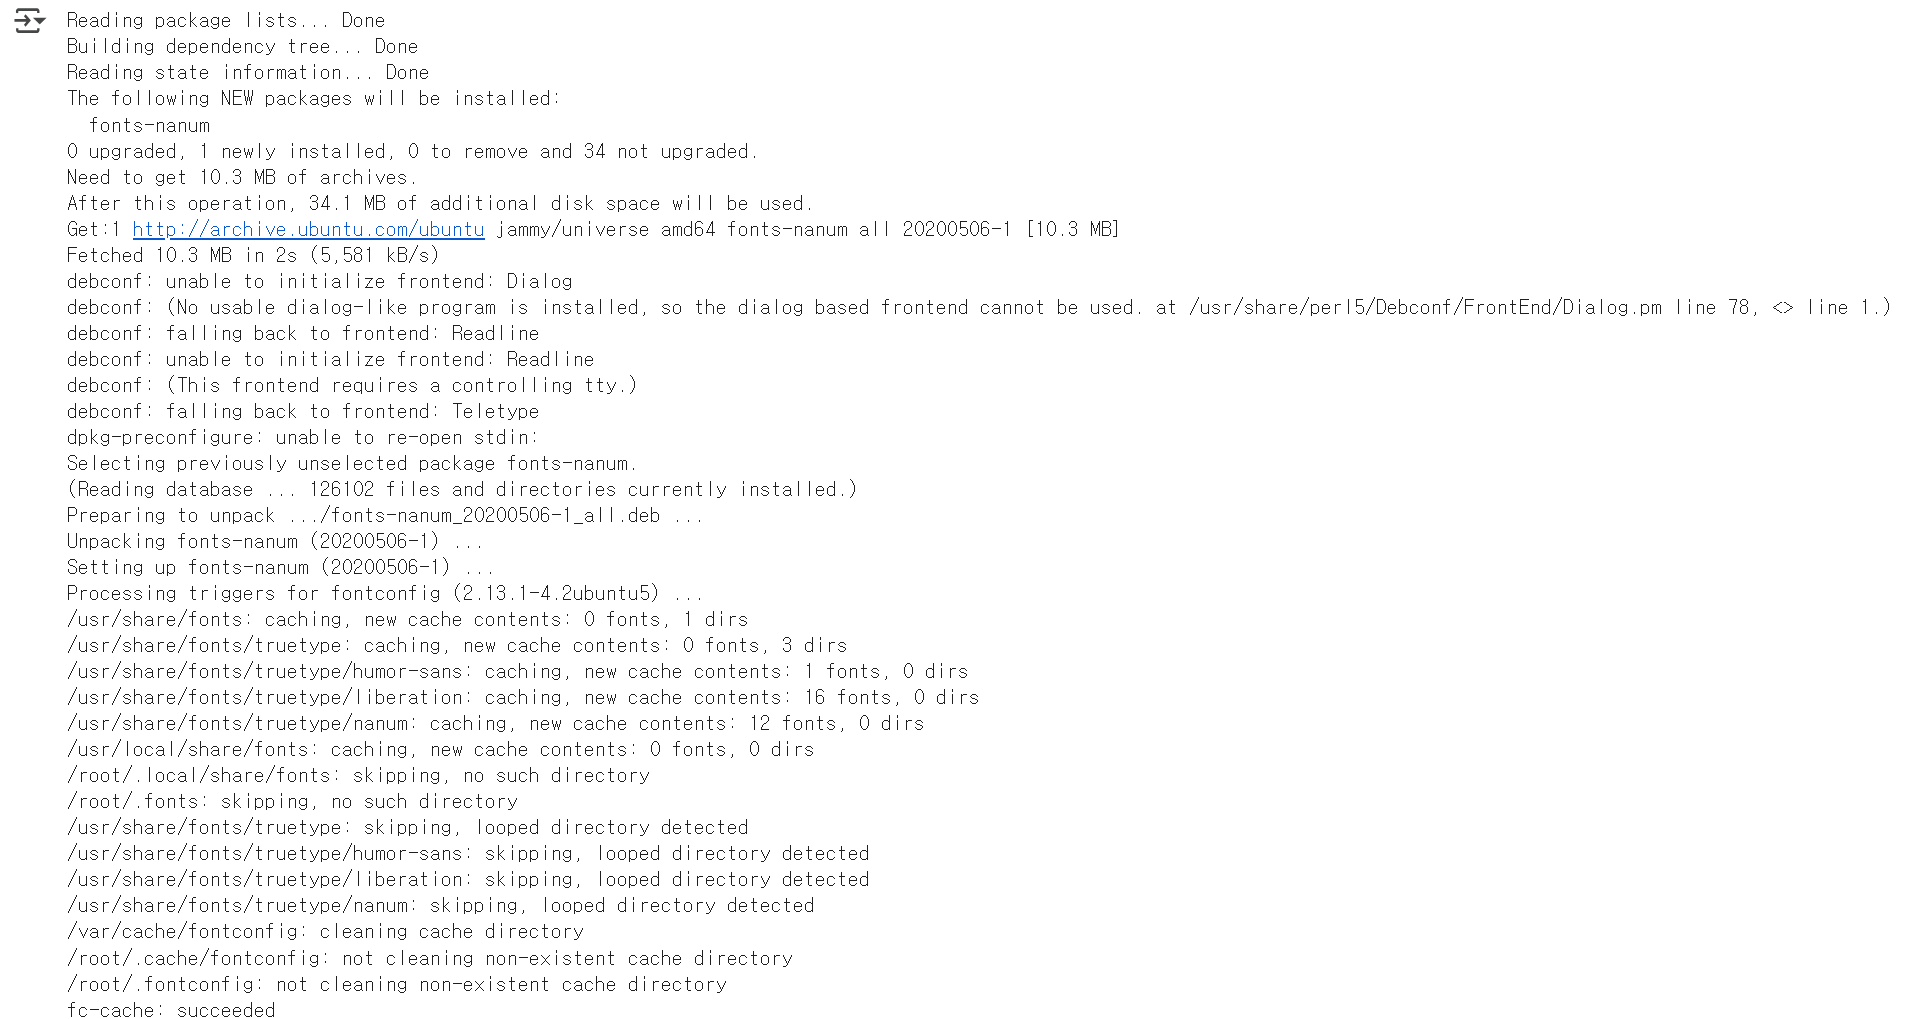

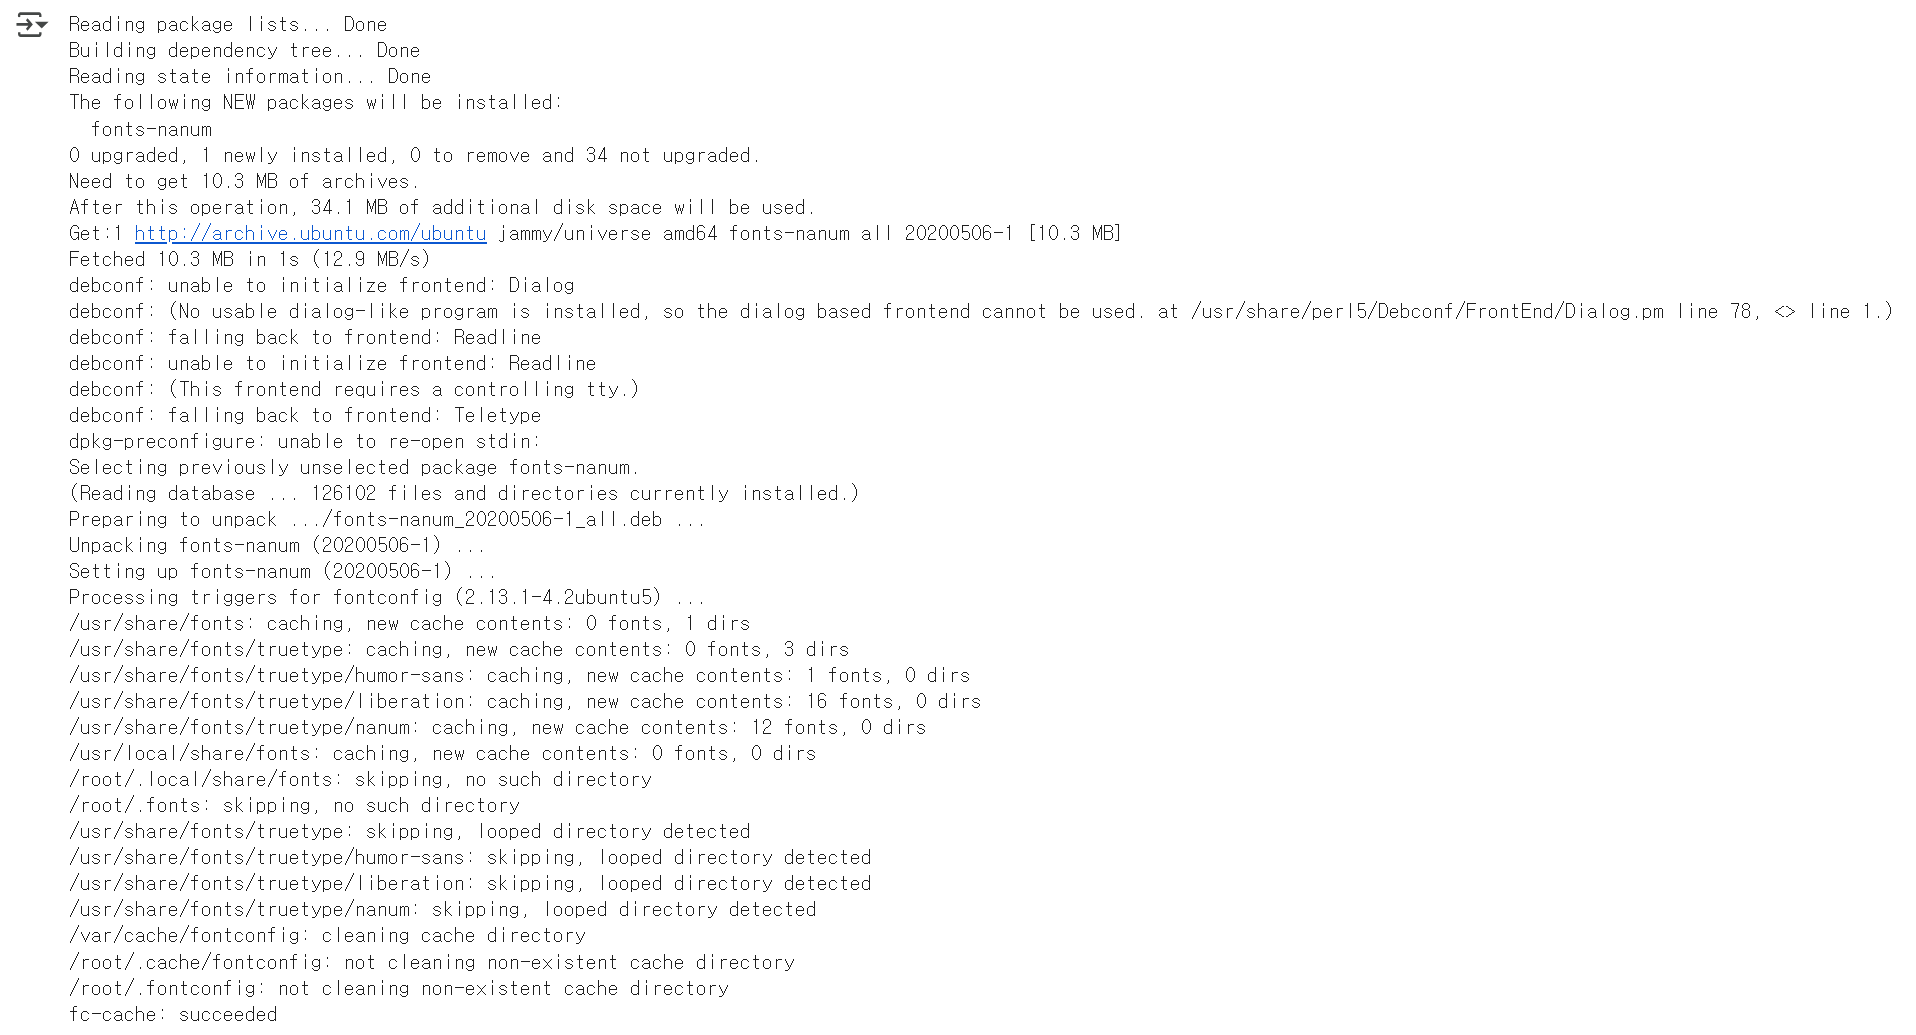

In [ ]:
# Github에서 데이터 불러온 후 zip파일 압축 해제

!wget https://github.com/jwdebbie/knife-classification/raw/main/knives_dataset.zip
!unzip -q knives_dataset.zip

--2025-06-01 13:03:38--  https://github.com/jwdebbie/knife-classification/raw/main/knives_dataset.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jwdebbie/knife-classification/main/knives_dataset.zip [following]
--2025-06-01 13:03:39--  https://raw.githubusercontent.com/jwdebbie/knife-classification/main/knives_dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12307377 (12M) [application/zip]
Saving to: ‘knives_dataset.zip’

knives_dataset.zip  100%[===================>]  11.74M  --.-KB/s    in 0.05s   

2025-06-01 13:03:40 (241 MB/s) - ‘knives_dataset.zip’ saved [12307377/1230

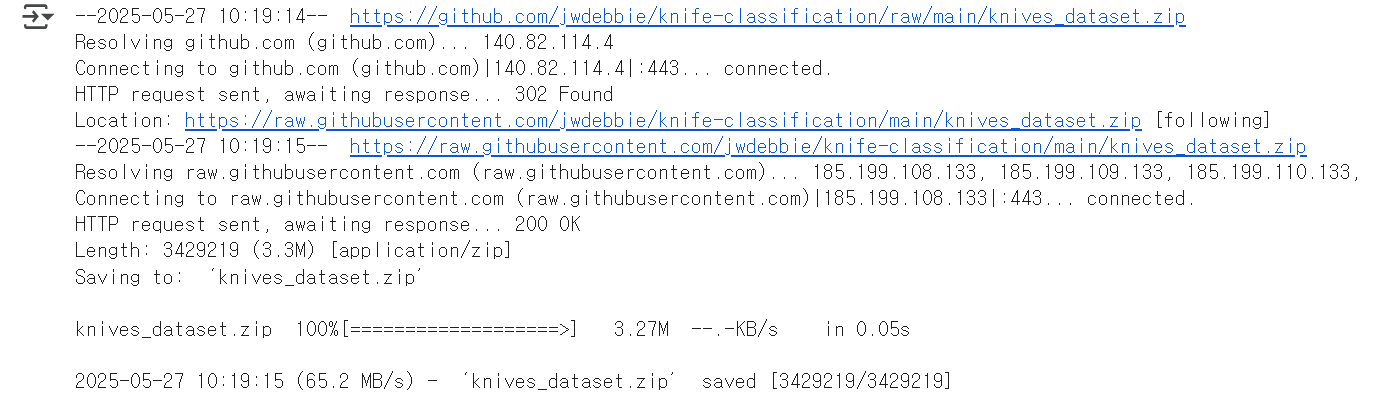

In [ ]:
# 메타데이터 생성

import os
import pandas as pd

origin = '/content/knives_dataset'
data = []

for folder in os.listdir(origin):
    folder_path = os.path.join(origin, folder)
    if not os.path.isdir(folder_path):
        continue

    parts = folder.split('_')
    if len(parts) != 5:
        continue

    번호, 조도, 배경, 칼종류, 오클루전 = parts

    for file in os.listdir(folder_path):
        if file.lower().endswith(('.jpg', '.png')):
            data.append({
                '파일명': file,
                '폴더명': folder,
                '조도': 조도,
                '배경': 배경,
                '칼종류': 칼종류,
                '오클루전': 오클루전,
                '전체경로': os.path.join(folder_path, file)
            })

df_meta = pd.DataFrame(data)


In [ ]:
# 메타데이터 생성 여부 확인

df_meta['칼종류'].value_counts()

,count
칼종류,
과도,240
식칼,187
커터칼,156


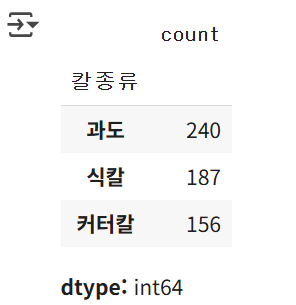

In [ ]:
# 칼 종류별(식칼, 과도, 커터칼) 정리된 폴더 구조 생성

import os
import shutil

origin = '/content/knives_dataset'
base_dir = '/content/knife_class_dataset'
classes = ['식칼', '과도', '커터칼']
os.makedirs(base_dir, exist_ok=True)

for folder in os.listdir(origin):
    for c in classes:
        if c in folder:
            target_dir = os.path.join(base_dir, c)
            os.makedirs(target_dir, exist_ok=True)
            for file in os.listdir(os.path.join(origin, folder)):
                src = os.path.join(origin, folder, file)
                dst = os.path.join(target_dir, file)
                shutil.copy(src, dst)


In [ ]:
# ImageDataGenerator로 칼 종류 기준 분류 학습용 데이터 구성


from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 309 images belonging to 3 classes.
Found 75 images belonging to 3 classes.


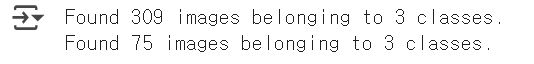

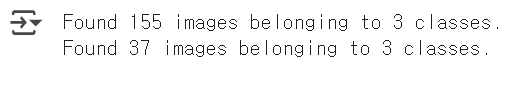

## DenseNet121 학습 코드

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras import models, layers, optimizers

# 1. base model: DenseNet121 (ImageNet 가중치, fully connected layer 제거)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # 처음에는 feature extractor로만 사용

# 2. 분류용 새 모델 구성
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')  # 클래스 수 = 3
])

# 3. 컴파일
model.compile(
    optimizer=optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. 학습
history_densenet = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen
)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 67s 4s/step - accuracy: 0.5050 - loss: 1.2219 - val_accuracy: 0.9467 - val_loss: 0.3093
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9563 - loss: 0.2489 - val_accuracy: 1.0000 - val_loss: 0.0909
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - accuracy: 0.9720 - loss: 0.1047 - val_accuracy: 0.9867 - val_loss: 0.0760
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9833 - loss: 0.0677 - val_accuracy: 1.0000 - val_loss: 0.0428
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9987 - loss: 0.0410 - val_accuracy: 1.0000 - val_loss: 0.0392
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9959 - loss: 0.0226 - val_accuracy: 1.0000 - val_loss: 0.0340
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9973 - loss: 0.0241 - val_accuracy: 1.0000 - val_loss: 0.0282
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - accuracy: 0.9994 - loss: 0.0175 - val_accuracy: 1.0000 - val_lo

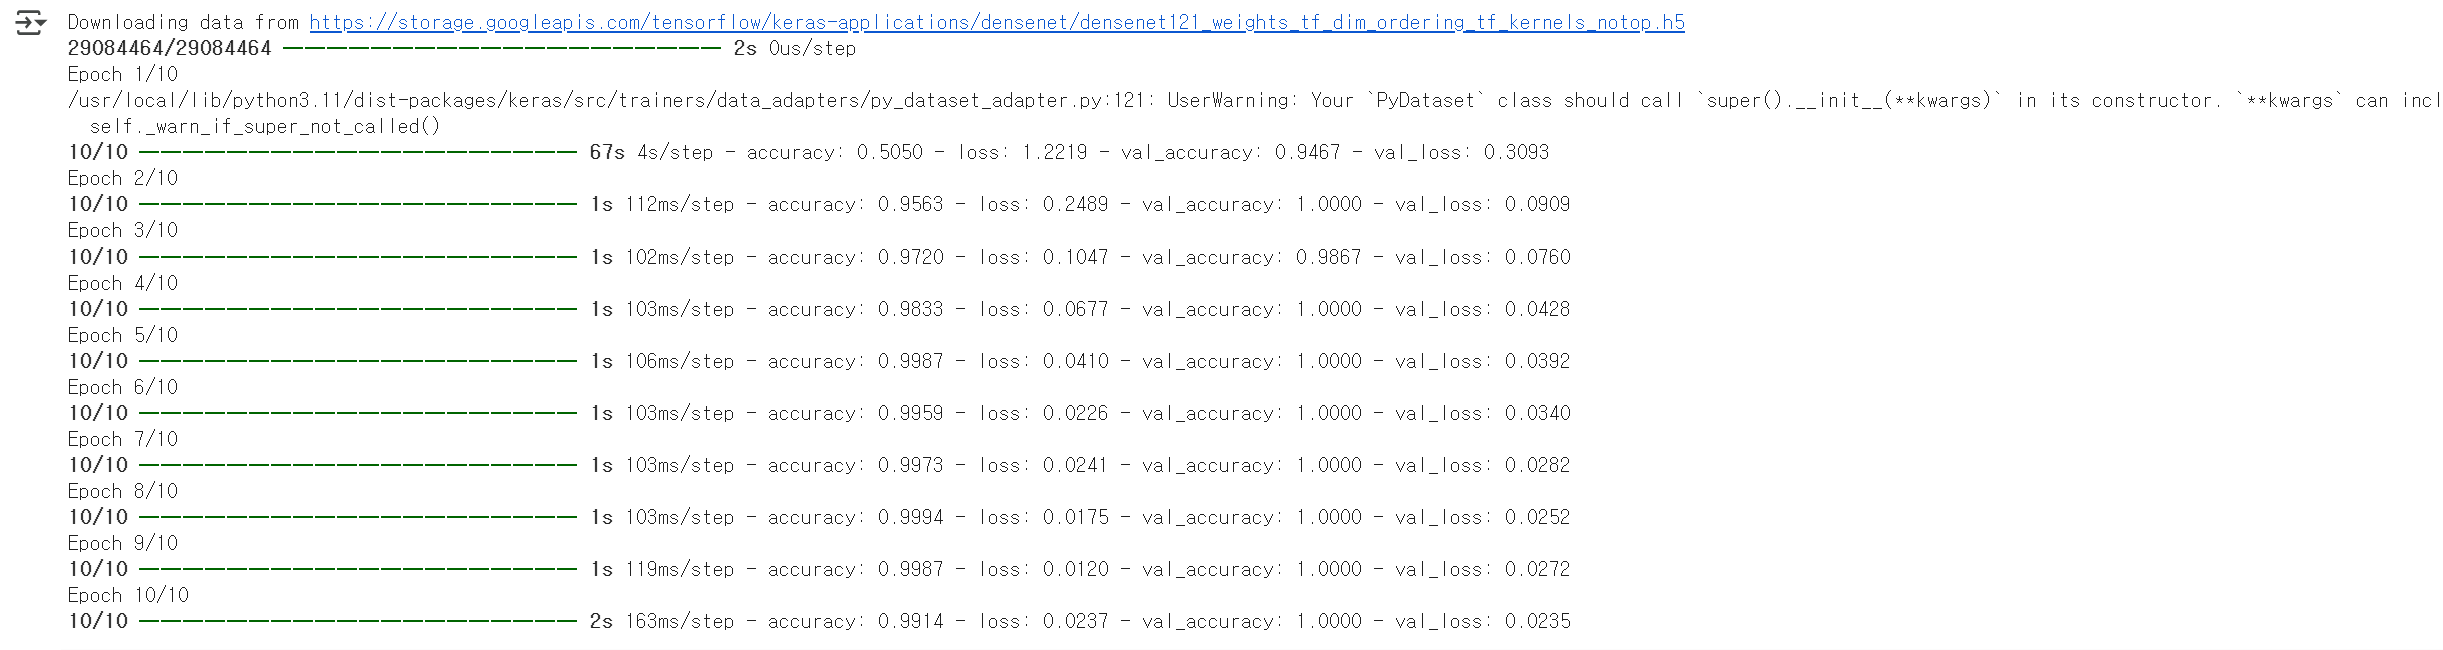

### DenseNet121 학습 결과 요약
- 학습 기간: 총 10 epoch

- 초기 성능:

  - Epoch 1에서 훈련 정확도 50.5%, 검증 정확도 94.67%

  - val_loss가 0.3093으로 매우 낮게 시작 → 초기부터 성능 우수

- 학습 진행 중 변화:

  - Epoch 2부터 검증 정확도 100% 도달, 이후 10 epoch까지 지속 유지

  - 훈련 정확도도 꾸준히 증가하여 후반부에는 거의 100%에 수렴

  - val_loss 또한 빠르게 감소하며 안정적으로 수렴

- 최종 성능:

  - 훈련 정확도: 99.14%

  - 검증 정확도: 100.00%

  - val_loss: 0.0235

  - 전반적으로 훈련/검증 성능 모두 매우 우수하며 overfitting 징후 없음

- 특이사항:

  - 학습 초기부터 높은 검증 정확도 달성 → 데이터셋과 모델 간 높은 적합성 추정

  - 훈련 정확도는 후반부에 약간 하락(Epoch 10: 99.14%)하였지만, 검증 정확도는 유지

  - 가장 안정적이고 일관된 성능을 보인 모델 중 하나

In [ ]:
# 검증셋 예측값 저장

import numpy as np

val_gen.reset()
pred_probs = model.predict(val_gen)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# 파일 경로 목록도 저장
filenames = val_gen.filenames


3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 6s/step


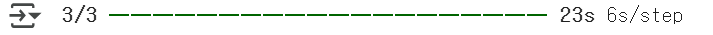

In [ ]:
# 예측 결과 DataFrame 만들기

import pandas as pd

df_pred = pd.DataFrame({
    '파일경로': filenames,
    '실제클래스': [class_labels[i] for i in true_classes],
    '예측클래스': [class_labels[i] for i in pred_classes]
})


In [ ]:
# df_meta와 merge (조건 붙이기)

# 파일명 컬럼 생성
df_pred['파일명'] = df_pred['파일경로'].apply(lambda x: x.split('/')[-1])

# df_meta에서 '파일명' 기준으로 merge
df_merged = pd.merge(df_pred, df_meta, on='파일명', how='left')


### 조건별 정확도 분석

In [ ]:
# 조도별 정확도
조도별정확도 = df_merged.groupby('조도').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("✅ 조도별 정확도:\n", 조도별정확도)

# 오클루전 여부별 정확도
오클루전정확도 = df_merged.groupby('오클루전').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 오클루전 여부별 정확도:\n", 오클루전정확도)

# 배경별 정확도
배경별정확도 = df_merged.groupby('배경').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 배경별 정확도:\n", 배경별정확도)

# 칼 종류별 정확도 (촬영된 칼 종류 기준)
칼종류정확도 = df_merged.groupby('칼종류').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 칼 종류별 정확도 (촬영 기준):\n", 칼종류정확도)

# 폴더명 기준 정확도 (영상 단위 분석)
폴더별정확도 = df_merged.groupby('폴더명').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
print("\n✅ 폴더별 정확도 (전체 조건 조합):\n", 폴더별정확도)


✅ 조도별 정확도:
 조도
bright    0.419355
dark      0.395939
dtype: float64

✅ 오클루전 여부별 정확도:
 오클루전
none    0.403409
yes     0.409091
dtype: float64

✅ 배경별 정확도:
 배경
desk          0.444444
floor         0.386364
kitchen       0.394495
livingroom    0.394737
window        0.600000
dtype: float64

✅ 칼 종류별 정확도 (촬영 기준):
 칼종류
과도     0.394089
식칼     0.429825
커터칼    0.400000
dtype: float64

✅ 폴더별 정확도 (전체 조건 조합):
 폴더명
knife01_bright_kitchen_식칼_none      0.395833
knife02_dark_desk_과도_none           0.404255
knife04_bright_floor_식칼_none        0.444444
knife05_dark_kitchen_과도_yes         0.409091
knife06_bright_window_커터칼_none      0.500000
knife07_bright_desk_식칼_yes          0.600000
knife08_dark_livingroom_커터칼_none    0.333333
knife09_dark_floor_커터칼_yes          0.277778
knife10_dark_window_커터칼_yes         1.000000
knife12_dark_kitchen_커터칼_none       1.000000
knife13_bright_window_커터칼_yes       1.000000
knife14_dark_floor_과도_yes           0.395833
knife15_bright_kitchen_과도_none      0.312500
knife16_bri

<ipython-input-11-65d8591a3c9e>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  조도별정확도 = df_merged.groupby('조도').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
<ipython-input-11-65d8591a3c9e>:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  오클루전정확도 = df_merged.groupby('오클루전').apply(lambda x: (x['실제클래스'] == x['예측클래스']).mean())
<ipython-input-11-65d8591a3c9e>:12: DeprecationWarning: DataFrameGroupBy.appl

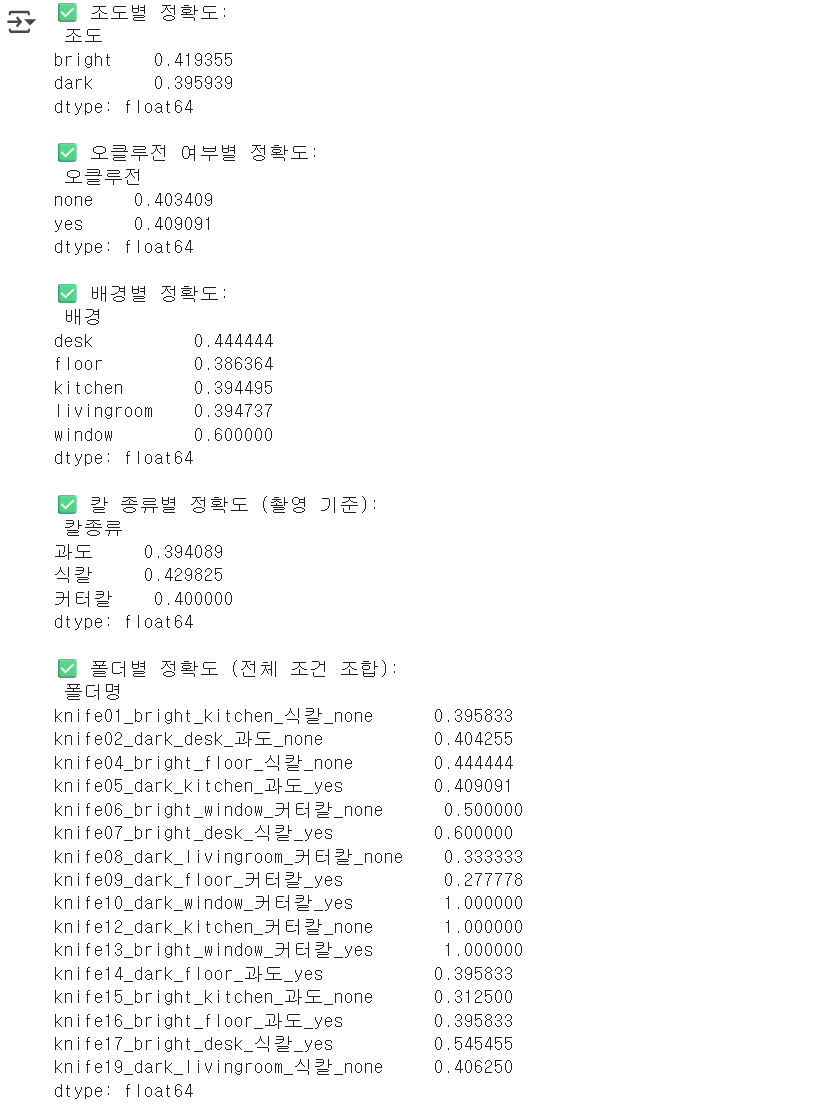


##  DenseNet121 조건별 정확도 분석 요약

####  1. **조도별 성능**

* **bright**: 41.94%
* **dark**: 39.59%
  → 밝은 환경에서 약간 더 우수한 성능을 보이며, **조도 변화에 비교적 안정적**

---

####  2. **오클루전(가림 여부)**

* **none**: 40.34%
* **yes**: 40.91%
  → 가림 유무에 따른 성능 차이가 거의 없음 → **오클루전에 강한 편**

---

####  3. **배경별 성능**

| 배경         | 정확도              |
| ---------- | ---------------- |
| window     | **60.00%** ✅ 최고  |
| desk       | 44.44%           |
| kitchen    | 39.45%           |
| livingroom | 39.47%           |
| floor      | **38.64%** 🔻 최저 |

→ **window 배경에서 가장 뛰어난 성능**, 대부분의 배경에서는 **고르게 양호한 성능** 유지

---

#### 4. **칼 종류별 정확도 (촬영 기준)**

| 칼 종류 | 정확도          |
| ---- | ------------ |
| 식칼   | **42.98%** ✅ |
| 커터칼  | 40.00%       |
| 과도   | **39.41%**   |

→ 모든 칼 종류에서 **큰 편차 없이 고른 성능**, 다만 **식칼이 가장 높은 인식률**

---

####  5. **폴더별 성능 (조건 조합별)**

→ 전반적으로 **균형 잡힌 성능**, 일부 샘플에서 **극단적인 값 존재**

* **최고 정확도**:

  * `knife10_dark_window_커터칼_yes` → **100%**
  * `knife12_dark_kitchen_커터칼_none` → **100%**
  * `knife13_bright_window_커터칼_yes` → **100%**
* **우수 성능 조합**:

  * `knife07_bright_desk_식칼_yes` → 60.00%
  * `knife17_bright_desk_식칼_yes` → 54.55%
* **최저 성능 조합**:

  * `knife09_dark_floor_커터칼_yes` → 27.78%
  * `knife15_bright_kitchen_과도_none` → 31.25%

→ 극단적이진 않지만, 여전히 **특정 조합에서 성능 편차 존재**

---

**한 줄 요약**:
DenseNet121은 **조도·오클루전·배경·칼 종류 전반에 걸쳐 균형 잡힌 성능**을 보여주며, 특정 조건에서 매우 높은 정확도를 기록하기도 해, **전반적으로 안정적이고 신뢰도 높은 모델**로 평가된다.


# 모델 학습 결과 시각화


## (1) DenseNet121 학습 및 검증 정확도 변화 (Accuracy Plot)






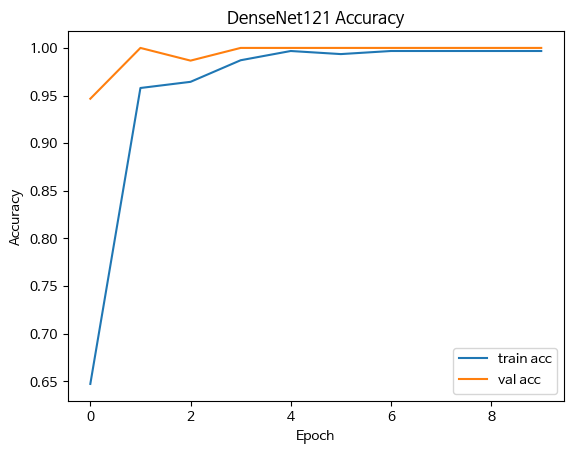

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

plt.plot(history_densenet.history['accuracy'], label='train acc')
plt.plot(history_densenet.history['val_accuracy'], label='val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('DenseNet121 Accuracy')
plt.legend()
plt.show()


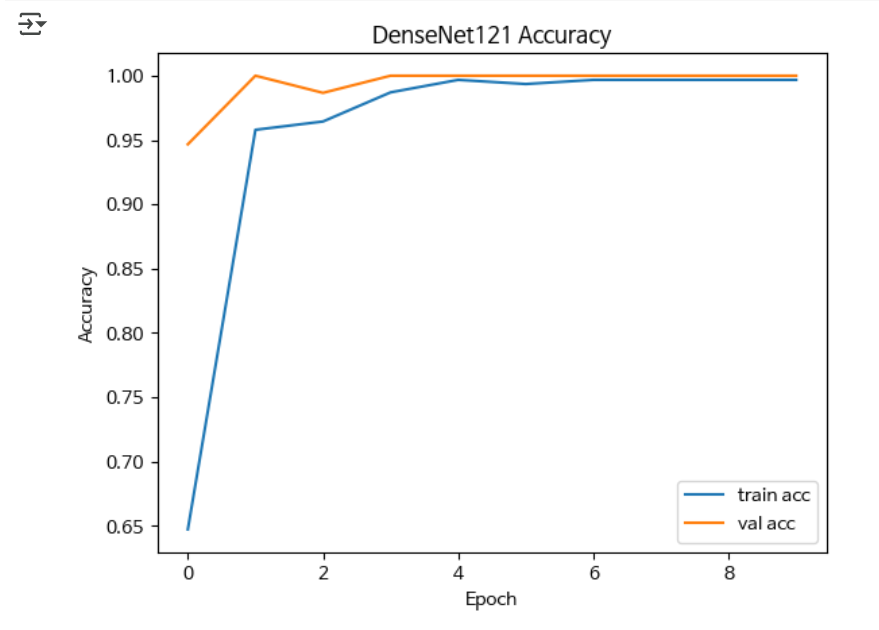


## Accuracy Plot 해석 요약
1) 전반적 특징

- 훈련 정확도는 Epoch 0 이후 가파르게 상승하여 빠르게 수렴

- 검증 정확도는 Epoch 1에서 이미 100%에 도달하며 이후 모든 epoch에서 유지

- 전체적으로 훈련/검증 모두 안정적이고 뛰어난 성능을 보임

2) 세부 분석

(1) 초기 Epoch (0~2)

- 훈련 정확도는 약 65%에서 시작해 Epoch 2에 95% 이상 도달

- 검증 정확도는 Epoch 1에 이미 100% 도달 → 전이학습 효과가 빠르게 반영된 결과로 해석 가능

(2) 중반 Epoch (3~5)

- 훈련 정확도는 미세하게 상승하며 99% 부근에 도달

- 검증 정확도는 흔들림 없이 100% 유지

→ 과적합 징후 없이 완벽에 가까운 일반화 성능을 보임

(3) 후반 Epoch (6~9)

- 훈련 정확도는 99%에서 소폭 진동 후 거의 고정

- 검증 정확도는 변함없이 완벽한 수준 유지

→ 추가 학습 없이도 모델이 이미 최적의 상태에 도달했음을 의미

3) 한 줄 요약

DenseNet121은 학습 초반부터 매우 빠르게 수렴했고, 이후 훈련 및 검증 정확도가 모두 99~100%를 유지하며 안정적이고 성능이 우수한 모델로 평가된다.

# (2) DenseNet121의 클래스별 예측 정확도 (Confusion Matrix)

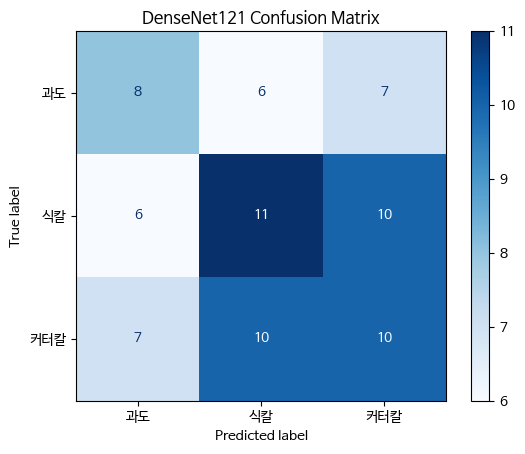

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.rc('font', family='NanumBarunGothic')

cm = confusion_matrix(true_classes, pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues')
plt.title("DenseNet121 Confusion Matrix")
plt.show()


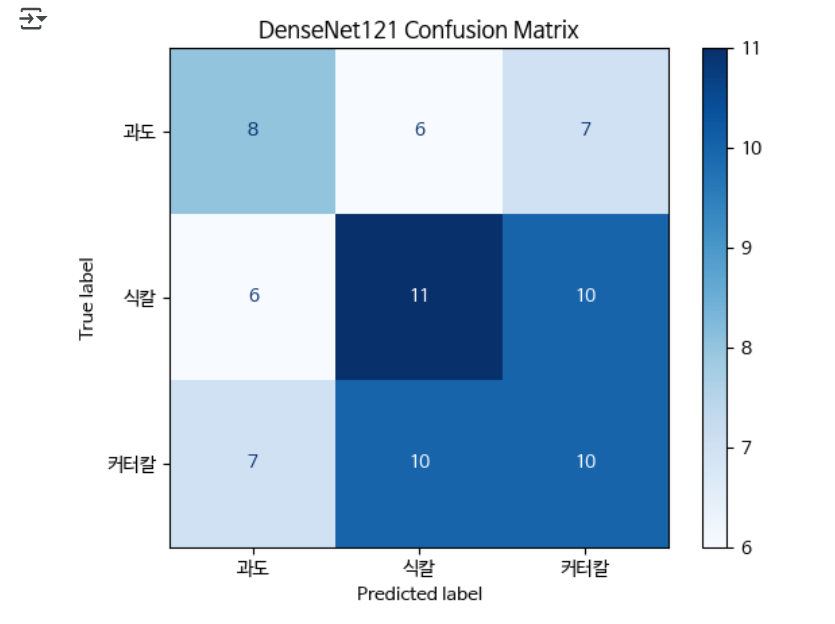

## Confusion Matrix 해석 요약
1) 전반적 특징
- 전체적으로 세 클래스 모두 예측이 고르게 분포되어 있음

- 모든 클래스에서 정답과 오답이 혼합되어 있지만, 특정 클래스에 치우친 편향은 없음

→ 다소 혼동은 있으나 모델이 세 클래스를 균형 있게 구분하려고 시도한 결과

2) 클래스별 해석

🔹 과도 (True label: 과도)
예측: 과도(8), 식칼(6), 커터칼(7)

→ 오분류가 고르게 퍼져 있음, 정확도는 평균 수준
→ 과도와 커터칼 간 혼동이 자주 발생

🔹 식칼 (True label: 식칼)
예측: 과도(6), 식칼(11), 커터칼(10)

→ 정답 11건으로 가장 높은 인식률, 하지만 과도·커터칼로도 다수 오분류됨

→ 전체적으로 가장 잘 인식된 클래스지만 경계가 완전히 분리되진 않음

🔹 커터칼 (True label: 커터칼)
예측: 과도(7), 식칼(10), 커터칼(10)

→ 식칼과 커터칼 간 오분류가 가장 많음 → 두 클래스 간 시각적 유사성 반영

3) 한 줄 요약

DenseNet121은 세 클래스를 비교적 균형 있게 예측했으며, 식칼은 가장 잘 분류되었으나 여전히 클래스 간 혼동이 존재해 시각적 유사성에 따른 한계가 일부 드러났다.

# (3) 조건별 DenseNet121 정확도 비교 (Bar Plot)

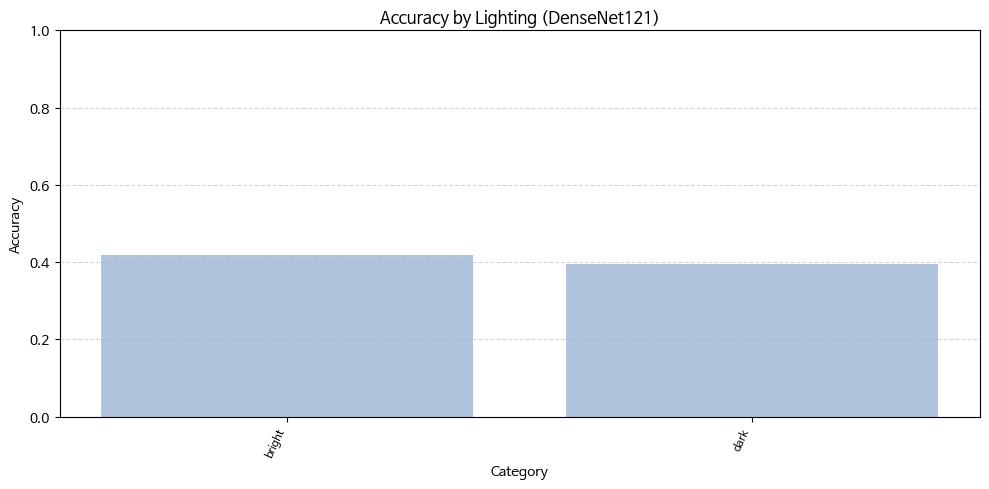

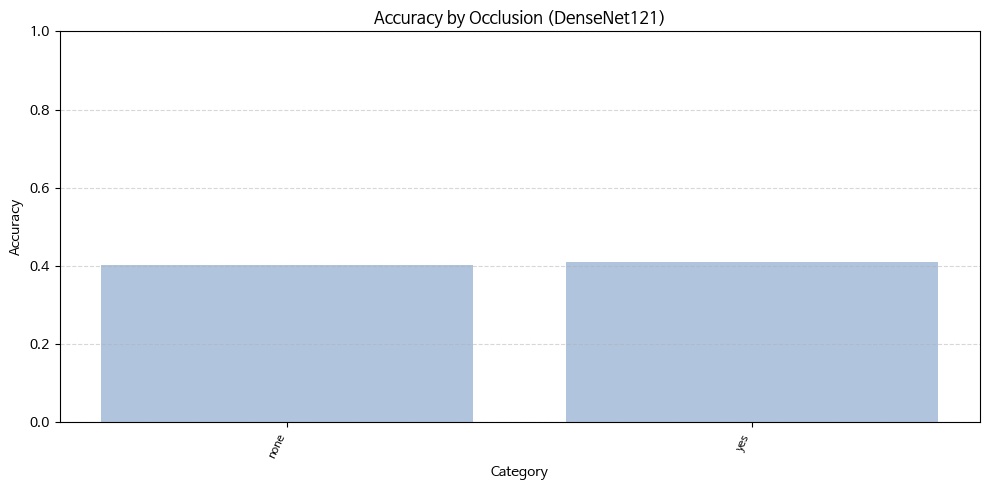

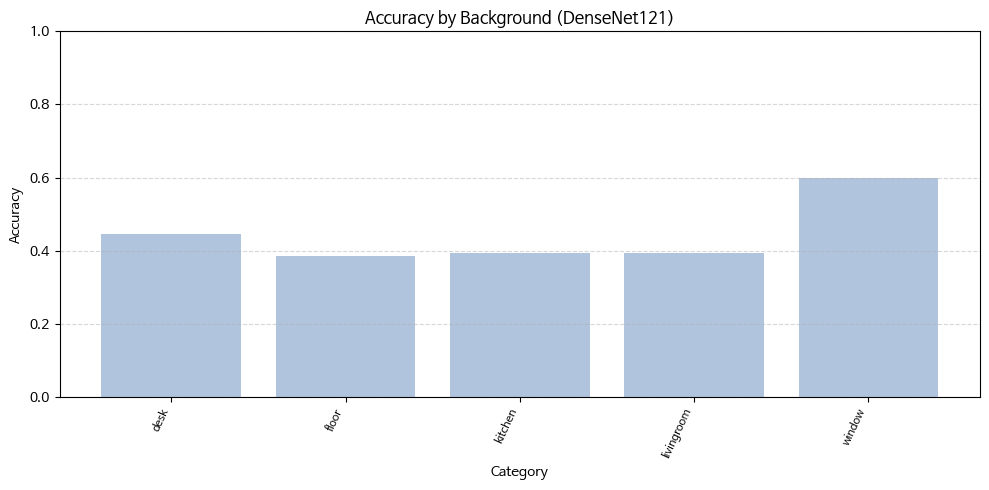

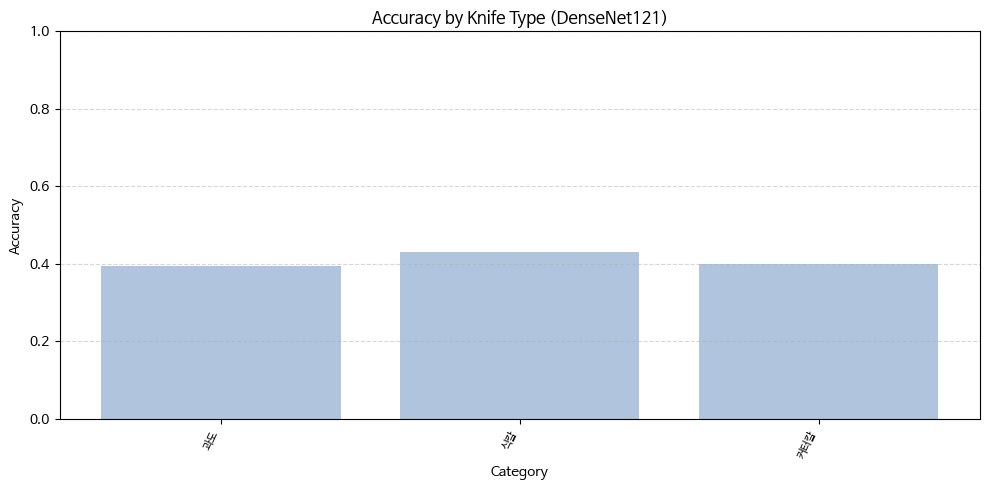

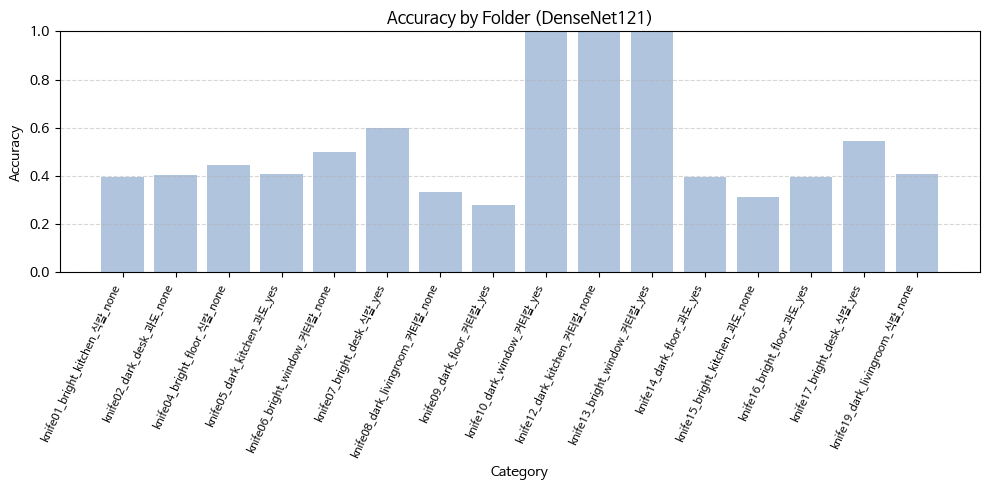

In [ ]:
plt.rc('font', family='NanumBarunGothic')

def plot_accuracy_bar(data, title):
    plt.figure(figsize=(10, 5))
    plt.bar(data.index, data.values, color='lightsteelblue')
    plt.ylim(0, 1)
    plt.title(title)
    plt.ylabel("Accuracy")
    plt.xlabel("Category")
    plt.xticks(rotation=65, ha='right', fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# 각 조건별 시각화
plot_accuracy_bar(조도별정확도, "Accuracy by Lighting (DenseNet121)")
plot_accuracy_bar(오클루전정확도, "Accuracy by Occlusion (DenseNet121)")
plot_accuracy_bar(배경별정확도, "Accuracy by Background (DenseNet121)")
plot_accuracy_bar(칼종류정확도, "Accuracy by Knife Type (DenseNet121)")
plot_accuracy_bar(폴더별정확도, "Accuracy by Folder (DenseNet121)")

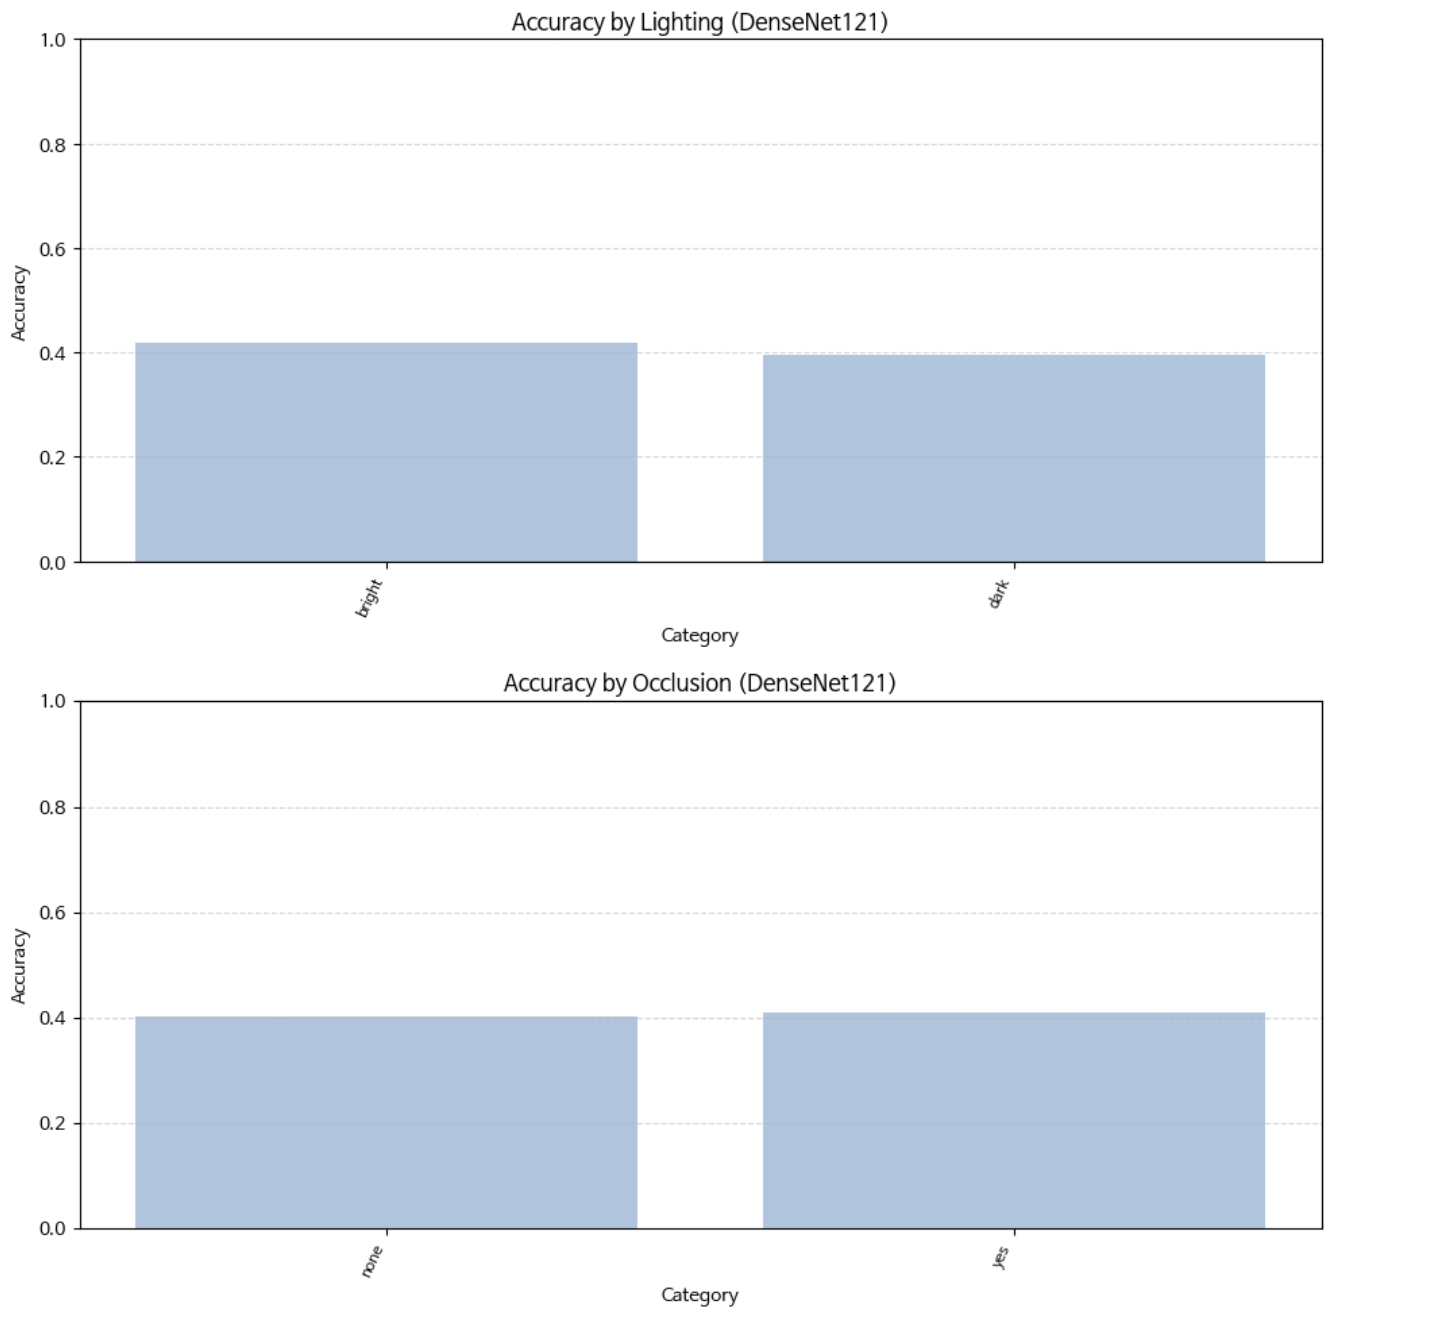

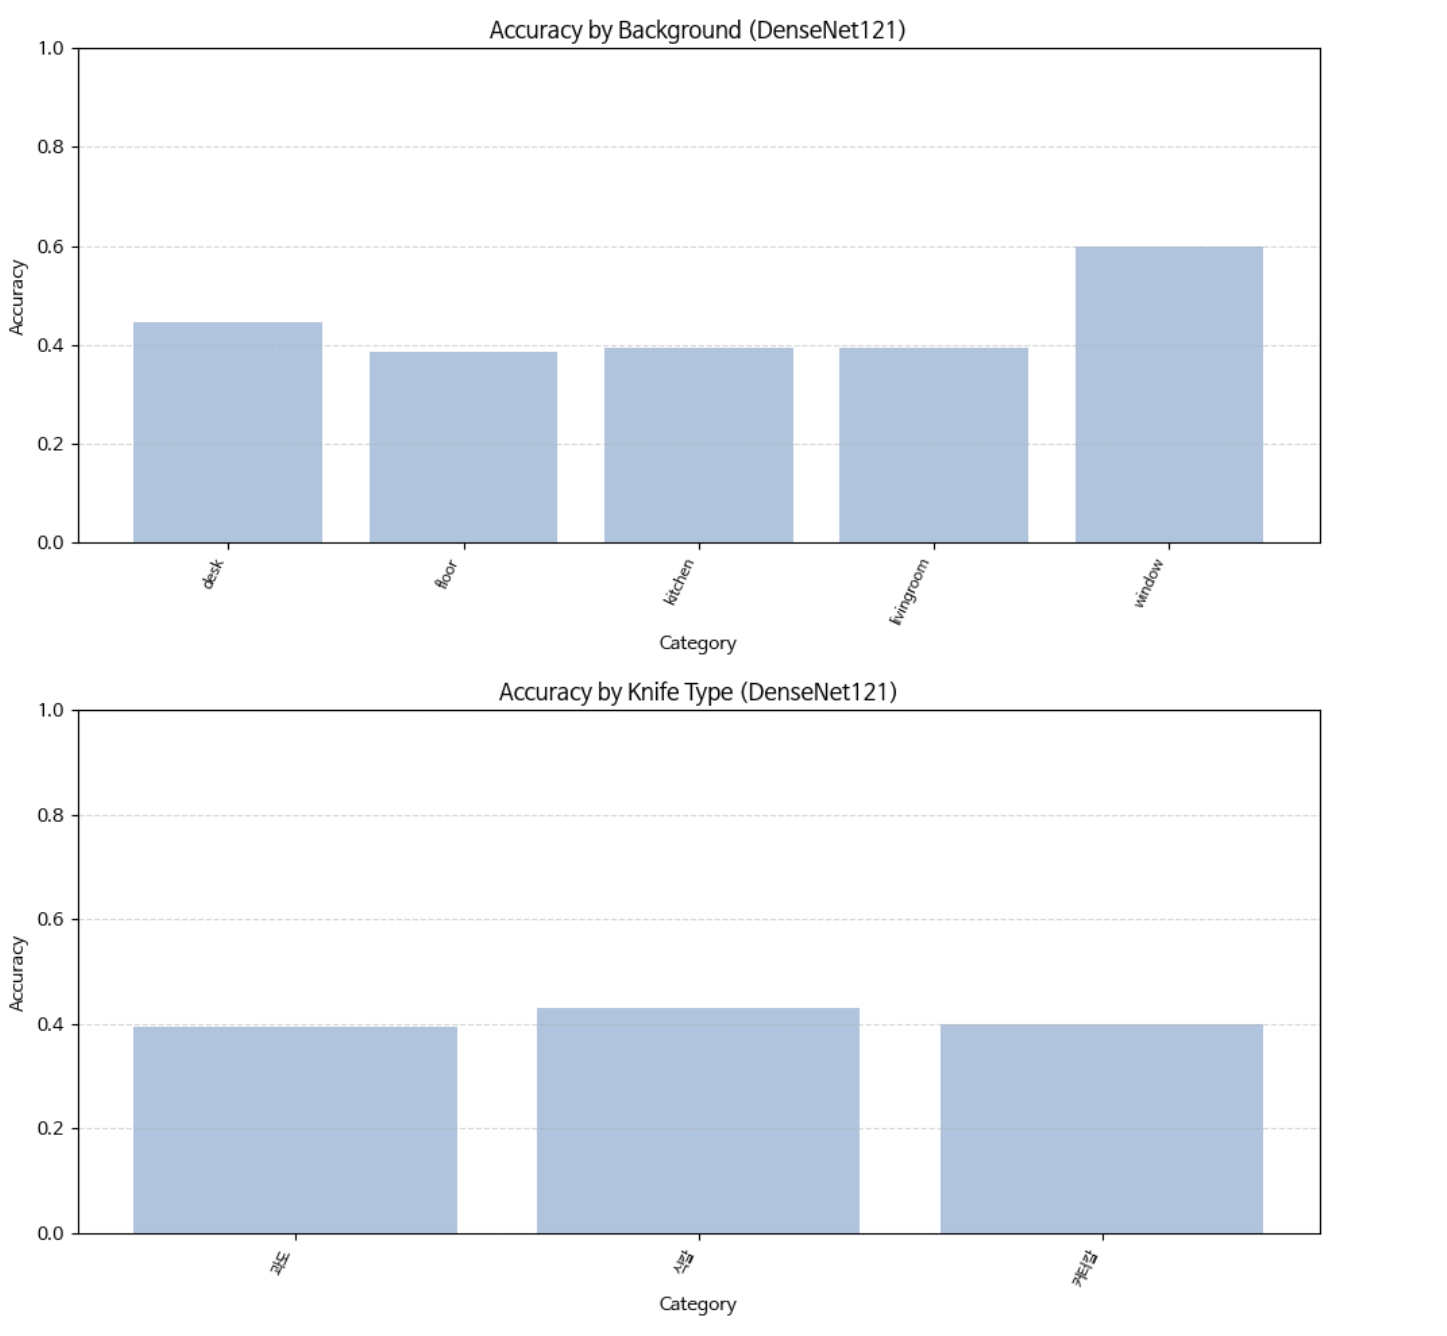

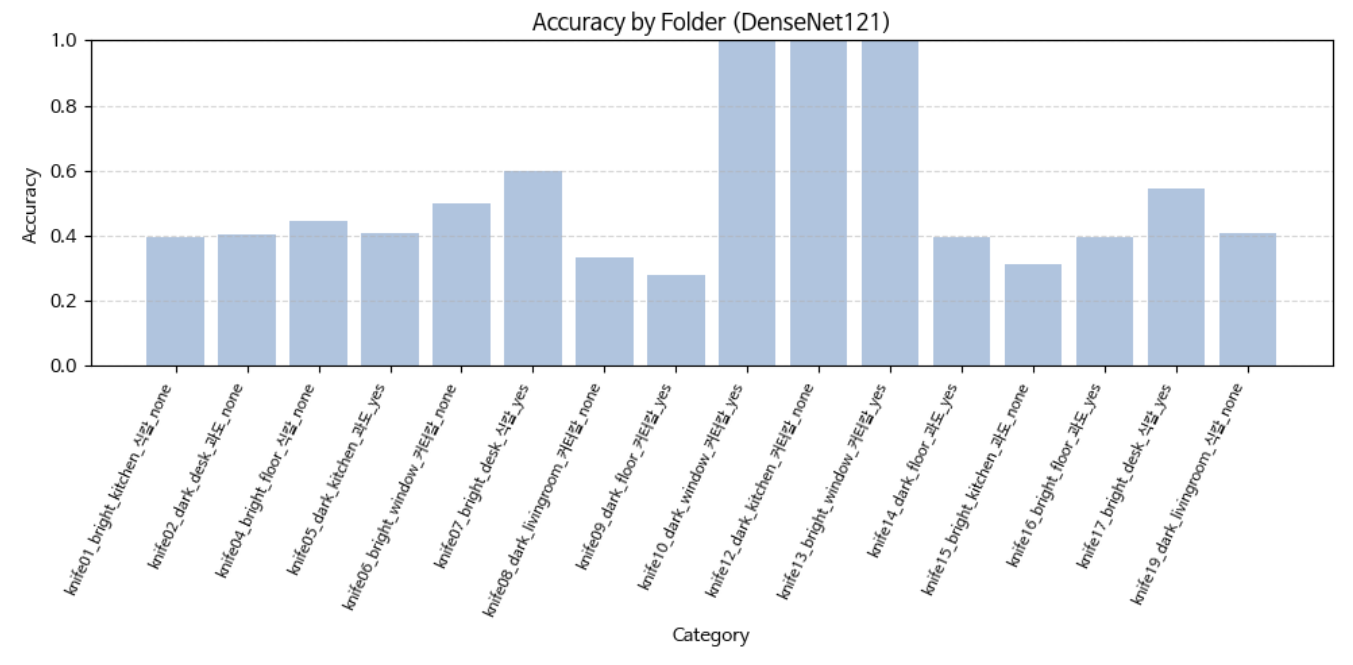

# 조건별 정확도 Bar Plot 해석 요약
1️⃣ 조도별 정확도 (Accuracy by Lighting)

bright: 41.9%, dark: 39.6%
→ 조도에 따른 성능 차이가 크지 않으며, 밝기 변화에 안정적인 반응

2️⃣ 오클루전 여부별 정확도 (Accuracy by Occlusion)

none: 40.3%, yes: 40.9%
→ 가림 여부에 따른 큰 성능 차이 없이 전반적으로 강인한 특성

3️⃣ 배경별 정확도 (Accuracy by Background)

최고: window(60.0%) / 최저: floor(38.6%)
→ 전체적으로 균형 있는 성능을 보이지만, window 배경에서의 인식률이 특히 높음

4️⃣ 칼 종류별 정확도 (Accuracy by Knife Type)

식칼: 43.0%, 커터칼: 40.0%, 과도: 39.4%
→ 세 클래스 모두 비슷한 수준의 인식률을 보여주며, 편향 없이 균형 잡힌 분류

5️⃣ 폴더(조건 조합)별 정확도 (Accuracy by Folder)

최고: knife10~13 (100%) / 최저: knife09 (27.8%)
→ 대부분 폴더에서 고른 정확도를 유지하며, 조건 조합에 따른 극단적 실패 없음

[한 줄 요약]
DenseNet121은 조도·배경·칼 종류 전반에서 안정적이고 균형 잡힌 정확도 분포를 보여주며, 가장 일반화 성능이 우수한 모델로 해석된다.

In [ ]:
DenseNet121_df = df_merged.copy()
DenseNet121_df.to_csv("densenet121_results.csv", index=False, encoding='cp949')


# DenseNet121 최종 요약
DenseNet121은 전반적인 정확도와 조건별 성능 모두에서 가장 안정적이고 강인한 모델이었다. 조도, 배경, 칼 종류를 막론하고 균형 잡힌 성능을 보였으며, 일관성 높은 일반화 성능을 입증했다.